# 1. Introduction

Today time series forecasting is ubiquitous, and decision-making processes in companies depend heavily on their ability to predict the future. Through a short series of articles I will present you with a possible approach to this kind of problems, combining state-space models with Bayesian statistics.

In the initial articles, I will take some of the examples from the book *An Introduction to State-Space Time Series Analysis* from Jacques J.F. Commandeur and Siem Jan Koopman [1]. It comprises a well-known introduction to the subject of state-space modeling applied to the time series domain.

My contributions will be:

* A very humble attempt to close the gap between these two fields in terms of introductory and intermediate materials.
* The presentation of concepts: on the one hand, a concise (not non-existent) mathematical basis to support our theoretical understanding and, on the other hand, an implementation from scratch of the algorithms (whenever possible, avoiding “black box” libraries). In my opinion, it is the best way to make sure that we can grasp an idea.
* The proper implementation of the proposed models using PyMC3 as well as their interpretation and discussion.

This post belongs to a series, feel free to check the previous post to acquire some more context:
1. [The First Step in Bayesian Time Series— Linear Regression](https://towardsdatascience.com/the-first-step-in-bayesian-time-series-linear-regression-89a64b826a7e)
2. [First Bayesian State-Space Model with PyMC3](https://towardsdatascience.com/first-bayesian-state-space-model-with-pymc3-51cbb06ef8bd)

Also, you can always find all the data and code in my [GitHub](https://github.com/luisroque/bayesian_time_series).

# 2. Stochastic level model

In [183]:
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
from scipy import stats
import math
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm
import statsmodels.formula.api as smf
import theano
import theano.tensor as tt
import pymc3 as pm
import pandas as pd
import seaborn as sns
import warnings
from pymc3.distributions import distribution
from pymc3.distributions.continuous import Flat, Normal
from decimal import Decimal
from datetime import datetime, timedelta
from collections import OrderedDict

az.style.use('arviz-darkgrid')
warnings.filterwarnings('ignore')

In the last article, we defined and implemented the deterministic level model. We built it from the ground up, which introduced us important concepts. Nonetheless, we couldn't really capture the latent dynamic behaviour in our data. This time and to change that, we will make use of stochastic parameters. The *stochastic level model* is a generalization of our first model, the *deterministic level model*. The model is again a very simple, but it is an important piece that we are adding to our toolbox. When people refer to *local level models* they are usually referring to these types of models and not so much to the deterministic ones. The real change here is that we allow our level to vary, it is no longer deterministic, which means that the component is applied locally (hence the name).

## 2.1 Model definition

Now, we have a new equation to consider. The model can be written as

$$\begin{aligned}
y_t &= \mu_t + \epsilon_t, \quad \epsilon_t \sim NID(0, \sigma^2_\epsilon) \\
\mu_{t+1} &= \mu_t + \xi_t, \quad \xi_t \sim NID(0, \sigma^2_\xi)
\end{aligned}$$

for $t=1,...,n$, where $\mu_t$ is the unobserved level at time $t$, $\epsilon_t$ is the observation disturbance (or sometimes referred as irregular component) at time $t$ and $\xi_t$ is the level disturbance at time $t$.

The first equation is called the *measurement* equation and the second is our *state* equation. The second equation is what help us model our dependencies in time, as the state at time $t+1$ is a function of the state at time $t$.

### 2.1.1 Random walk

Before moving on, we need a little more of intuition. You'll see the concept of *random walk* thrown around in almost every financial time series paper or textbook. The simplest random walk that we can think of is an a one-dimensional walk, using a straight line. The person has to decide one direction or the other, moving forward or backward. Let’s imagine that the decision on its next step is taken by flipping a coin. If the coin falls heads up the walker takes a step forward; if the coin falls tails up the walker takes a step backwards. This is a random walk. We can see the more formal definition:

*In mathematics, a random walk is a mathematical object, known as a stochastic or random process, that describes a path that consists of a succession of random steps on some mathematical space such as the integers.*  [[*2*]](https://en.wikipedia.org/wiki/Random_walk)

In the same article we can see that it is a very common behaviour in nature as much as it is in the human nature. The examples include the path traced by a molecule as it travels in a liquid or a gas, the search path of a foraging animal, the price of a fluctuating stock and the financial status of a gambler can all be approximated by random walk models. 

Now that we have defined it, let's see how exactly it looks like. Let's draw a 1-D and a 2-D random walks. We need define an origin (e.g. $y=0$ for 1-D and $(x=0, y=0)$ for 2-D) and then, as we said earlier, choose a step to move with equal probability.

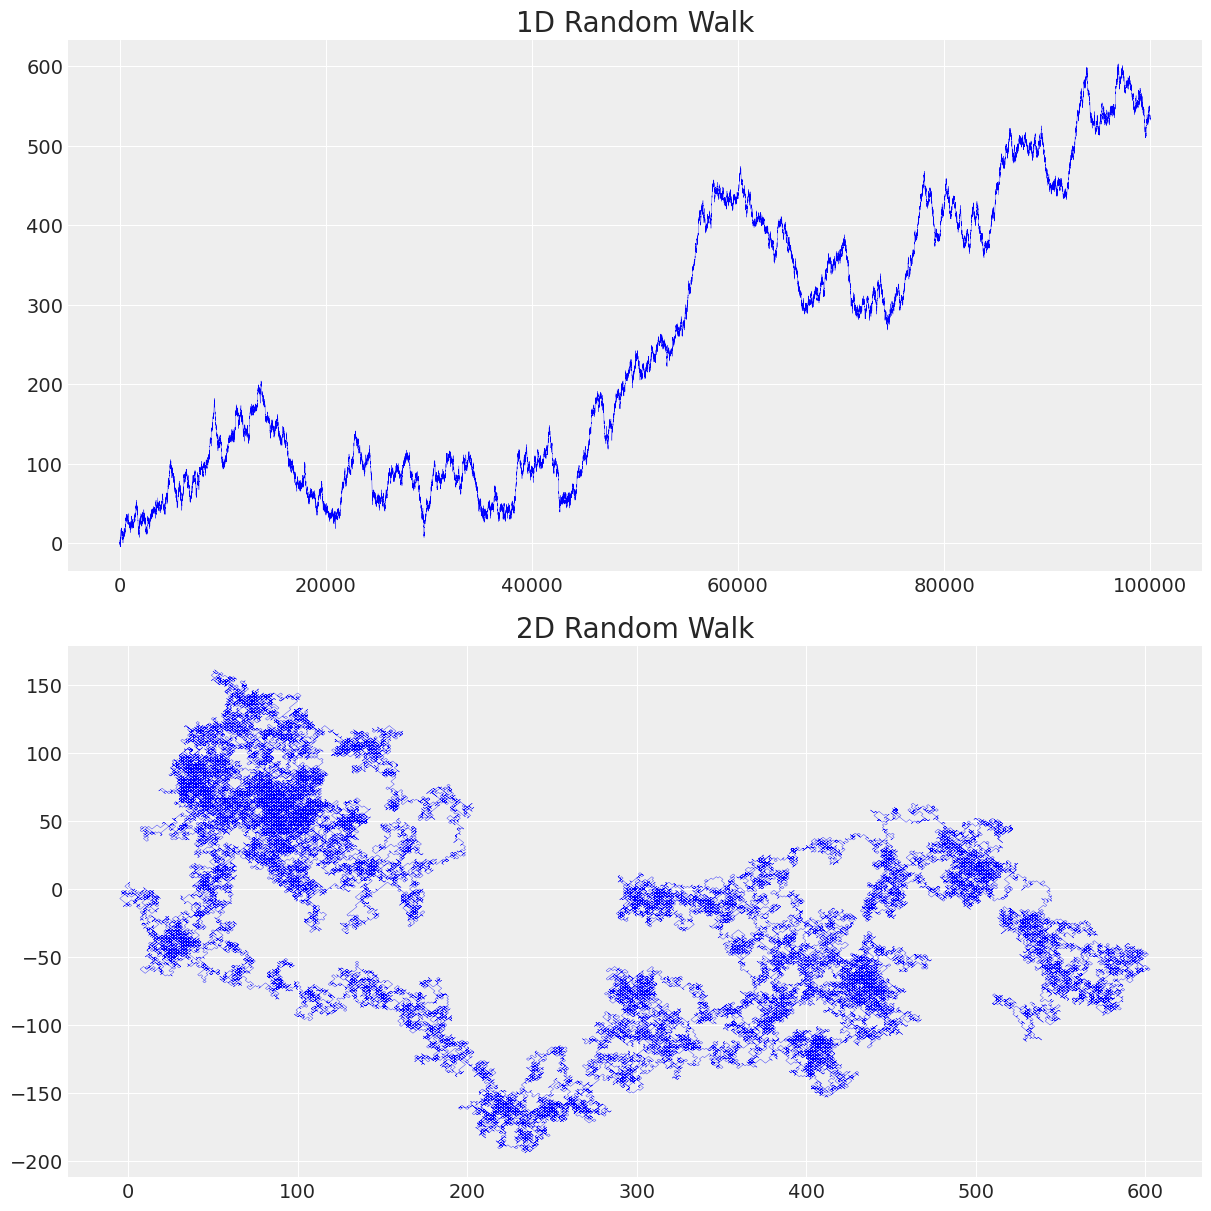

In [21]:
n_steps = 100000
random_walk = np.zeros((n_steps,2))
origin = np.zeros((1,2))
steps = np.random.choice(a=[-1,1],size=(n_steps, 2))
random_walk = np.concatenate([origin, steps]).cumsum(0)

_, ax = plt.subplots(2, 1, figsize=(12,12), constrained_layout=True)

ax[0].plot(random_walk[:,0],c='b',alpha=1,lw=0.25,ls='-')
ax[0].set_title('1D Random Walk', fontsize=20)
ax[1].plot(random_walk[:,0], random_walk[:,1],c='b',alpha=1,lw=0.25,ls='-')
ax[1].set_title('2D Random Walk', fontsize=20);

Let's investigate the distribution of our steps. We are taken discrete steps in a random fashion, so we are expecting an equal number of $-1$ and $1$ drawn for all the time steps. 

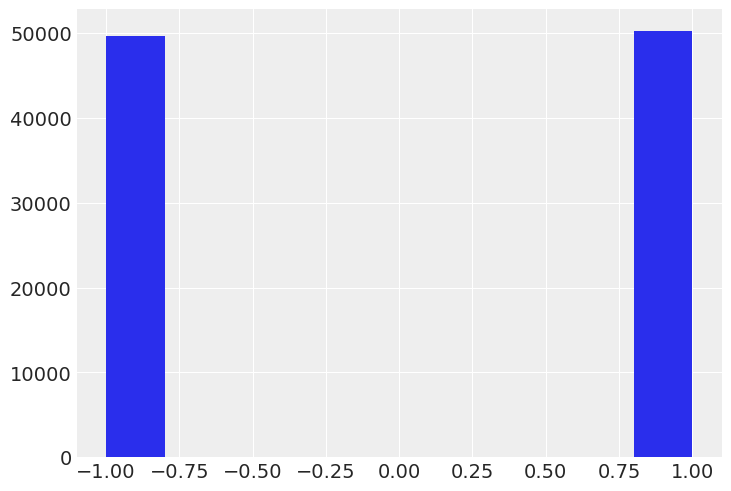

In [26]:
plt.hist(steps[:,0]);

Just as an exercise, we can describe even better this distribution. It is a discrete distribution to start and we are just randomly choosing from a list of two possible values. So we can model it with a binomial distribution with parameters $n$ (equal to the number of steps) and $p$ (probability of success - in our case could be choosing $1$). 

It can be written as 

$$\begin{aligned}
X &\sim B(n,p) \\
P(x;n,p) &= {n \choose x}p^x(1-p)^{n-x}
\end{aligned}$$

where $n \in \mathbb{N}$ and $p \in [0,1].$


Let's plot it and understand some of its properties.

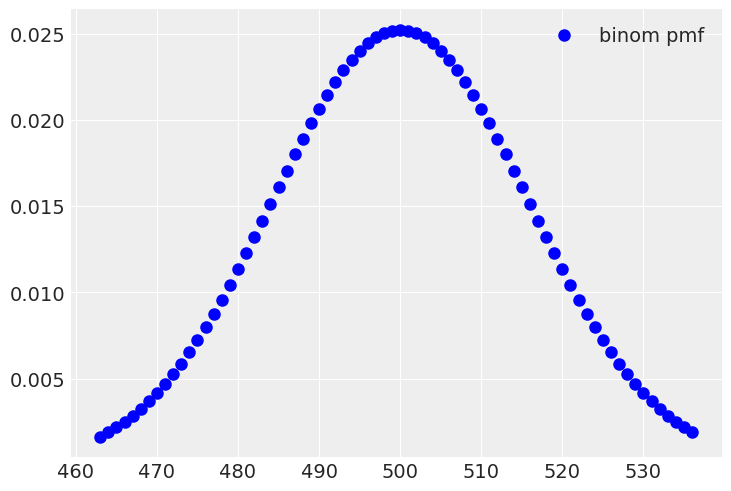

In [53]:
fig, ax = plt.subplots(1, 1)
p=0.5
x = np.arange(stats.binom.ppf(0.01, n_steps/100, p),
              stats.binom.ppf(0.99, n_steps/100, p))
ax.plot(x, stats.binom.pmf(x, n_steps/100, 0.5), 'bo', ms=8, label='binom pmf')
ax.legend();

We are plotting $1/100$ of the number of steps that we used above just to make sure that they follow a discrete distribution and not a continuous one. We should make sure that we get the expected 50% of probability of getting $1$ (considering $1$ our success and $p=0.5$). Because it is a discrete distribution we have to sum all the possible values up to the 50% point. This is called the *cumulative distribution function*.

It can be expressed as

$$P(X \leq x) = \sum^{\lfloor x \rfloor}_{i=0}{n \choose i}p^i(1-p)^{n-i}$$

where $\lfloor x \rfloor$ is the greatest integer less than or equal to x.

In [52]:
np.sum([stats.binom.pmf(i, n_steps/100, 0.5) for i in range(int(n_steps/100/2))])

0.48738749091112366

In [30]:
stats.binom.cdf(n_steps/100/2, n_steps/100, 0.5)

0.5126125090888417

Both lines above are doing the same thing, but as you see we are not getting exactly 50%. This is due to the fact that when $n$ is small, the probability of a deviation from 50% is significant. If one increases the number of trials, for instance, to $n = 100000$, the result will move closer to 50%. As $n$ approaches infinity, the outcome will approach 50%.

In [69]:
stats.binom.cdf(n_steps/2, n_steps, 0.5)

0.5012615631976961

Just our of curiosity, a random variable that follows a binomial distribution, for a sufficient large $n$ (more than sufficient in our case), can be approximated by a normal distribution with the parameters:

$$\mu = np \qquad \sigma^2 = np(1-p)$$

That is why our plot for the binomial distribution above resembles so much a gaussian distribution. 

In [62]:
print('μ = ' + str(n_steps/100*p))
print('σ = ' + str(n_steps/100*p*(1-p)))

μ = 500.0
σ = 250.0


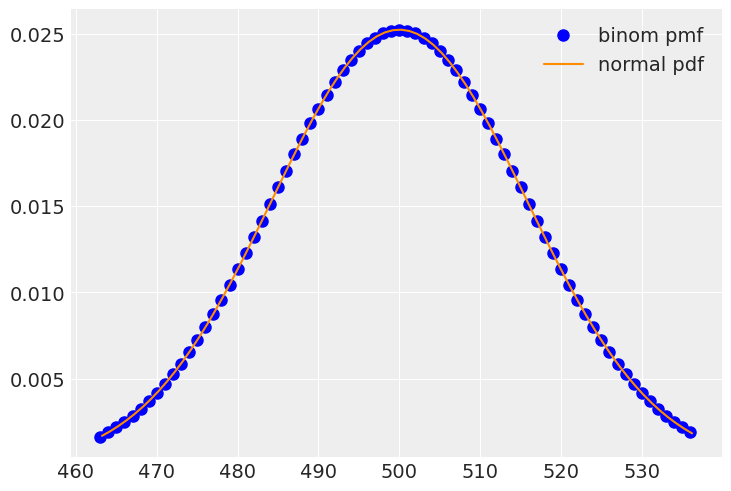

In [67]:
fig, ax = plt.subplots(1, 1)
p=0.5
x = np.arange(stats.binom.ppf(0.01, n_steps/100, p),
              stats.binom.ppf(0.99, n_steps/100, p))
ax.plot(x, stats.binom.pmf(x, n_steps/100, 0.5), 'bo', ms=8, label='binom pmf')
x = np.arange(stats.norm.ppf(0.01, n_steps/100*p, np.sqrt(n_steps/100*p*(1-p))),
              stats.norm.ppf(0.99, n_steps/100*p, np.sqrt(n_steps/100*p*(1-p))))
ax.plot(x, stats.norm.pdf(x, n_steps/100*p, np.sqrt(n_steps/100*p*(1-p))), color='darkorange', ms=8, label='normal pdf')
ax.plot()
ax.legend();

As we were expecting, the normal probability density function is basically superimposed. 

### 2.1.1 Gaussian Random walk

To make our case, let's draw our step directly from a gaussian distribution. It is the usuall way to define it and often the one that yields the best results in real-world applications.

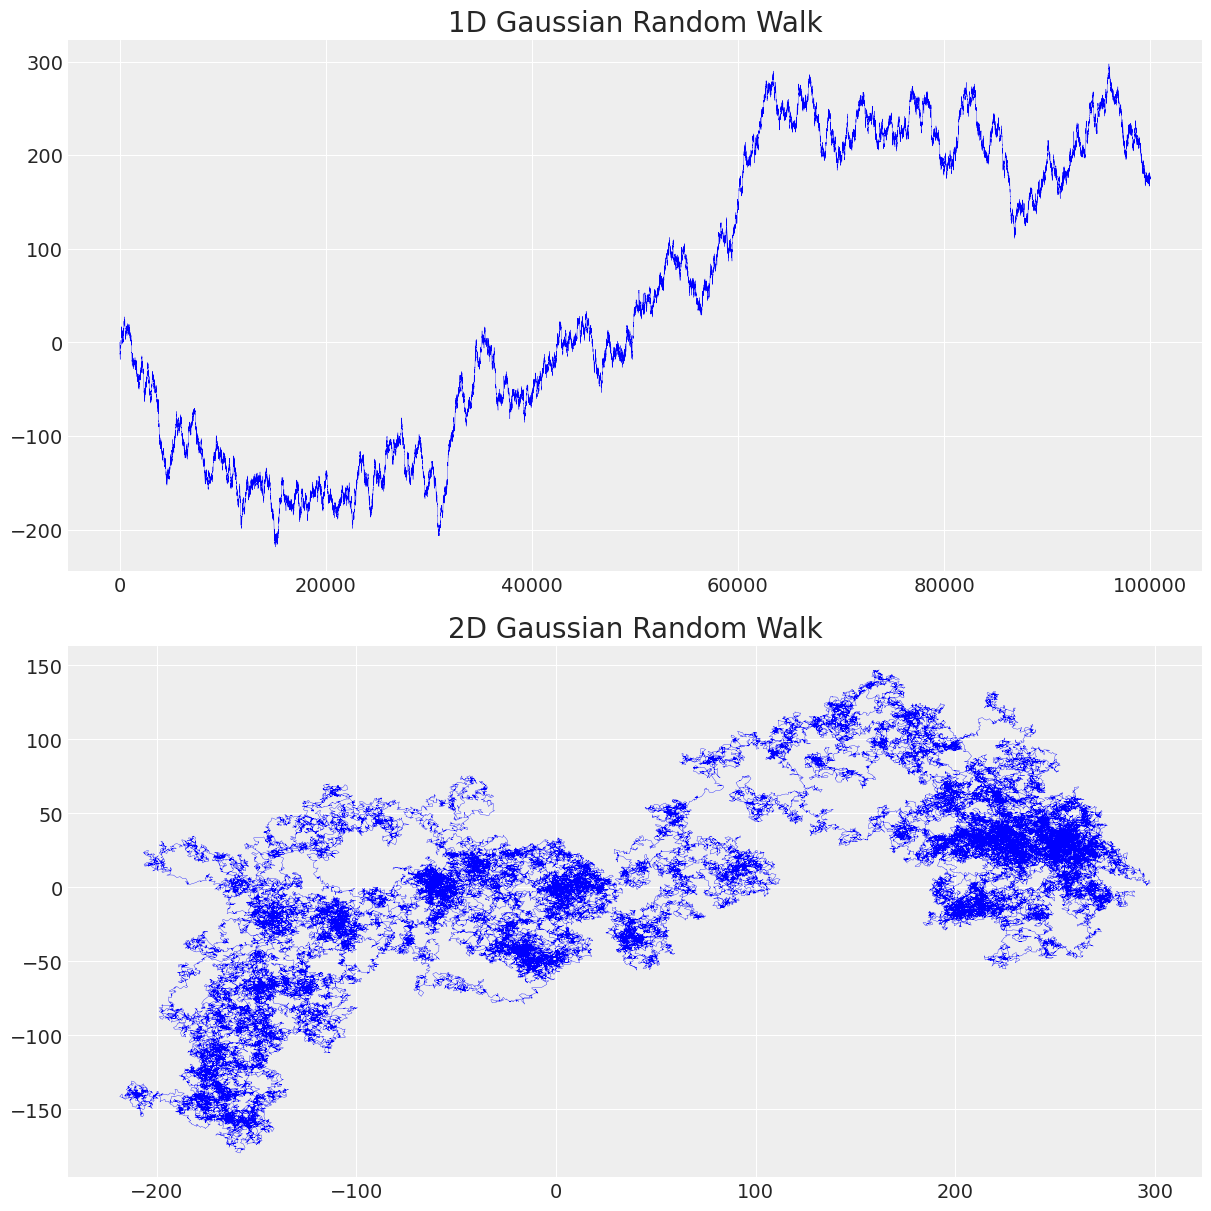

In [22]:
n_steps = 100000
random_walk = np.zeros((n_steps,2))
origin = np.zeros((1,2))
steps = np.random.normal(loc=0,scale=1,size=(n_steps, 2))
random_walk = np.concatenate([origin, steps]).cumsum(0)

_, ax = plt.subplots(2, 1, figsize=(12,12), constrained_layout=True)

ax[0].plot(random_walk[:,0],c='blue',alpha=1,lw=0.25,ls='-')
ax[0].set_title('1D Gaussian Random Walk', fontsize=20)
ax[1].plot(random_walk[:,0], random_walk[:,1],c='blue',alpha=1,lw=0.25,ls='-')
ax[1].set_title('2D Gaussian Random Walk', fontsize=20);

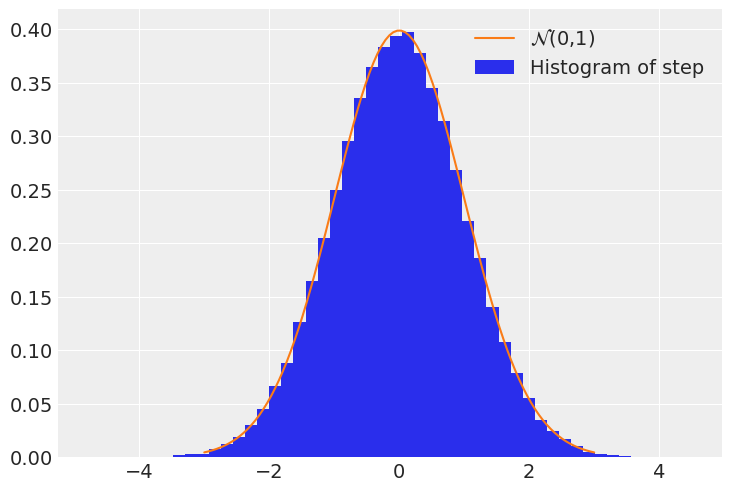

In [35]:
plt.hist(steps[:,0], bins=50, density=True, label='Histogram of step')
mu = 0
variance = 1
sigma = math.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma), label='$\mathcal{N}$(0,1)')
plt.legend();

The step is normally distributed with $\mu=0$ and $\sigma=1$. In fact, you can use any distribution for the step, whichever fits your data best. As we saw in the code above, the Random Walk behaviour is created by the cumulative sum of the steps. The way the steps are created is really up to you. The steps are usually referred as innovations.

An important distinction that I want you to always bear in mind is the difference between a *random process* and a random walk. A random process is stationary, because it consists of random variables independently and identically distributed. More than that, it implies that the process has a constant mean and variance, which is the very own definition of a stationary process. This is not the case with a random walk.

### 2.1.3 Stationarity

The random walk is a non-stationary process because the variance changes over time. Let's experiment with several draws.

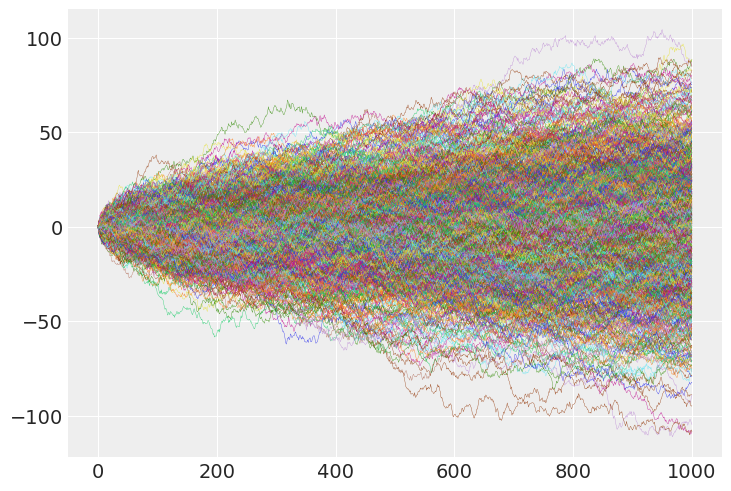

In [72]:
n_steps = 1000
random_walks = []
for i in range(1000):
    origin = np.zeros((1,1))
    steps = np.random.normal(loc=0,scale=1,size=(n_steps, 1))
    random_walk = np.concatenate([origin, steps]).cumsum(0)
    plt.plot(random_walk,alpha=1,lw=0.25,ls='-');

I hope it is clear that the variance grows with time. We can write it as

$$\begin{aligned}
Var(Y) &= Var(\epsilon_1 + \epsilon_2 +..+ \epsilon_3) \\
&= Var(\epsilon_1) + Var(\epsilon_2) +..+ Var(\epsilon_3) \\
&= \sigma^2 + \sigma^2 +...+ \sigma ^2 = t\sigma^2
\end{aligned}$$

Another aspect that shows the non-stationarity is the autocorrelations in the correlogram. It only starts to approach $0$ for a large number of lags.

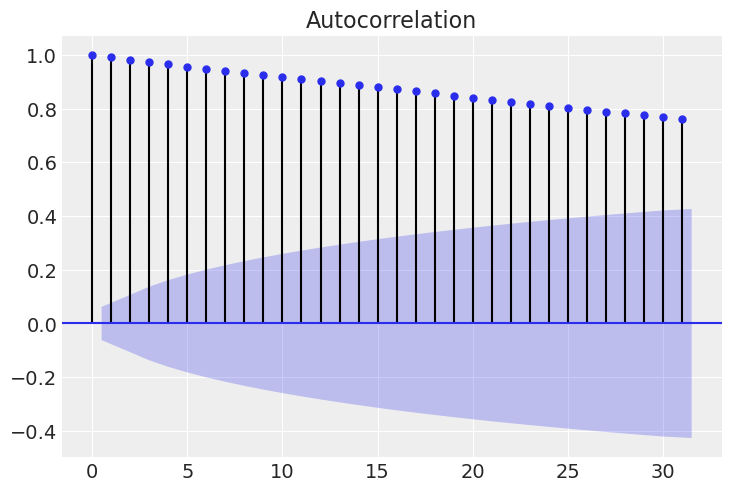

In [39]:
plot_acf(random_walk);

Stationarity plays a very important role in time series analysis, so we will make use of this concept often in future applications.

## 3. Classical implementation

As we usually do, let's start with the classical implementation before continuing to the Bayesian land. We'll be using the `statsmodel` library again.

In [91]:
ukdrivers = np.genfromtxt('./data/UKdriversKSI.txt', skip_header=True)
y = np.log(ukdrivers)
t = np.arange(1,len(y)+1)

model_ll = sm.tsa.UnobservedComponents(y, 
                                       'local level')
model_fit = model_ll.fit()

print(model_fit.summary())

                        Unobserved Components Results                         
Dep. Variable:                      y   No. Observations:                  192
Model:                    local level   Log Likelihood                 123.878
Date:                Thu, 10 Dec 2020   AIC                           -243.755
Time:                        12:07:07   BIC                           -237.251
Sample:                             0   HQIC                          -241.121
                                - 192                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular     0.0022      0.001      2.170      0.030       0.000       0.004
sigma2.level         0.0119      0.002      5.926      0.000       0.008       0.016
Ljung-Box (Q):              

Here we can see the Maximum Likelihood Estimation (MLE) of the variance of the irregular component and the level disturbance variance (if you want to understand better how this estimation works check my last article of the series).

## 4. The Bayesian Way

Now it is the time to implement our local level model with our Bayesian hats. I promised five implementations with five increasing levels of complexity. We will start with the *off-the-shelf* solution that `PyMC3` offers, since it has a built-in Gaussian Random Walk (GRW) class. Next, we will learn about some tweaks that we can use when the posterior distributions of our parameters are challenging to sample, namely when they are highly correlated. The third level is our first light attempt to manipulate `PyMC3` objects. In the fourth level, we will build our own GRW custom class. Finally, in the last level, we will make use of `Theano` to implement all the steps from scratch. 

Despite the fact that only the last level depends heavily on `Theano`, we will touch base on simple `Theano` functions or features across all implementations. So it makes sense to do small introduction on the topic. 

`PyMC3` is actually built on top of `Theano`. Theano, as per their own definition, is a Python library that allows you to define, optimize, and evaluate mathematical expressions involving multi-dimensional arrays efficiently [[*3*]](https://theano-pymc.readthedocs.io/en/latest/). For those who follow the deep learning landscape, you are probably aware that in 2017 the Theano original development team announced that they were stopping further developments. Soon after, the PyMC3 dev team took over the maintenance of the library. More recently, the team announced that PyMC4, that was being developed using TensorFlow Probability instead, will be discontinued and that Theano and JAX will be the computational backends for the future (read more here [[4]](https://pymc-devs.medium.com/the-future-of-pymc3-or-theano-is-dead-long-live-theano-d8005f8a0e9b)). 

### 4.1 The *off-the-shelf* solution

You can look at `PyMC3` as a toolbox. We pick up tools to work on our data and, as a result, shape the posterior distributions of our parameters. For this solution, we are using the `GaussianRandomWalk` class that `PyMC3` provides *off-the-shelf*. We are also following our equations, defined in the beginning of the article, line by line. We already know that in a Bayesian framework we define priors for each of our parameters and a likelihood for the data. In this case, we also define an adaptative prior, that is our Gaussian Random Walk latent process. It is called adaptative because we are not supplying parameters directly to it, but parameters distributions. This gives our model the ability to estimate its relevance based on the data.

In [97]:
with pm.Model() as m1:
    
    # Priors
    σ_ϵ = pm.HalfNormal('σ_ϵ', 1)
    σ_ξ = pm.HalfNormal('σ_ξ', 1)
    
    # Adaptative prior
    μ = pm.GaussianRandomWalk('μ', 
                              sigma=σ_ξ, 
                              shape=len(y))
    
    # Likelihood
    level = pm.Normal('level', 
                      mu=μ, 
                      sigma=σ_ϵ , 
                      observed=y)
    
    trace = pm.sample(2000,
                      target_accept=0.95,
                      init='advi+adapt_diag',
                      tune=3000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 42700
Interrupted at 42,699 [21%]: Average Loss = 1,435.7
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ_ξ, σ_ϵ]


Sampling 4 chains for 3_000 tune and 2_000 draw iterations (12_000 + 8_000 draws total) took 22 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8696556707220602, but should be close to 0.95. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


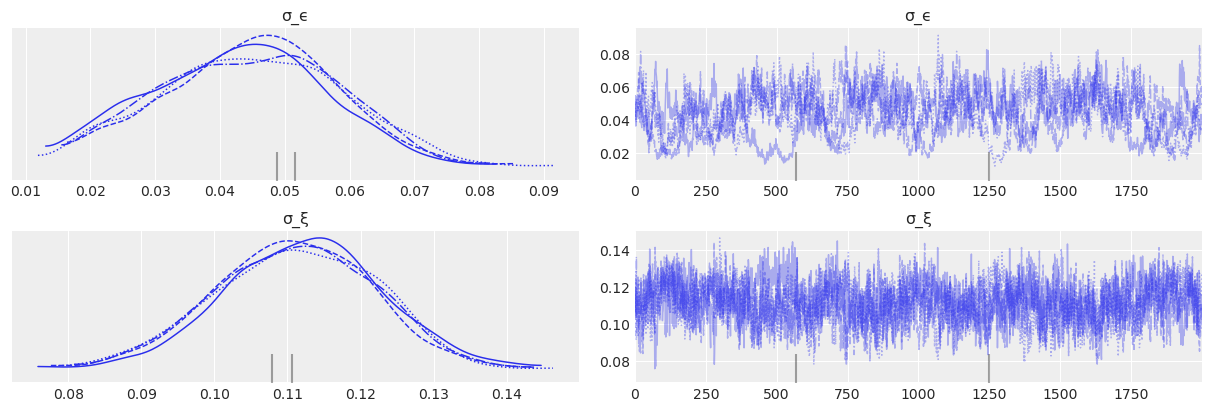

In [98]:
pm.traceplot(trace, var_names=['~μ']);

In [99]:
az.summary(trace, var_names=['~μ'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
σ_ϵ  0.044  0.013   0.019    0.067      0.001    0.001     138.0   138.0   
σ_ξ  0.111  0.011   0.091    0.131      0.001    0.000     257.0   252.0   

     ess_bulk  ess_tail  r_hat  
σ_ϵ     137.0     195.0   1.01  
σ_ξ     257.0     701.0   1.00

In [100]:
print('σ_ϵ = ' + str(np.mean(trace['σ_ϵ'])))
print('σ_ξ = ' + str(np.mean(trace['σ_ξ'])))

σ_ϵ = 0.044255232922781745
σ_ξ = 0.11123900825071306


We are recovering our parameters well enough, but the sampling was not very smooth, which could get us strange looking results. The first thing to point out is the number of divergences, it immediatelly shows that something is off. Another important metric is the `ess_mean`, the number of effective samples that we got from sampling 2000 draws for each parameter. For instance, for σ_ϵ we only got close to 100 valid samples, which shows that our posterior shape is quite hard to explore. The third thing to check is the `r_hat`. The metric shows the convergence between multiple chains of the same sampling process. Without defining it explicitly (you can do it in the `pm.sample` method), `PyMC3` will always sample four chains by default. The idea is to compare the within-chain variances with the variance off all chains mixed together [[5]](http://www.mcmchandbook.net/HandbookChapter6.pdf). If you achieve convergence, the `r_hat` should be equal to 1. In real-world applications and with hard posterior shapes, this number should be very close to 1 (not necessarily exactly one). In our case, `σ_ϵ` shows light signs of non-convergence. Finally, the trace plot is another source of information when talking about convergence. A well mixed trace plot does not show any pattern, it should resemble white noise. Again, `σ_ϵ` does show patterns in its traceplot, in fact, near zero it seems to show some random walk behaviour (we already know how to spot it). This is a typical indication of a hard shape of the posterior on that area, which makes the sampler mix very slowly, i.e. it gets stuck on that area for several iterations. If we would plot an ACF, as we have been doing to analyze our time series, we would clearly see high correlations slowly decreasing across lags for that region.

What could be producing such problems you may ask?

Let's plot the joint distribution of our parameters to get some more insights.

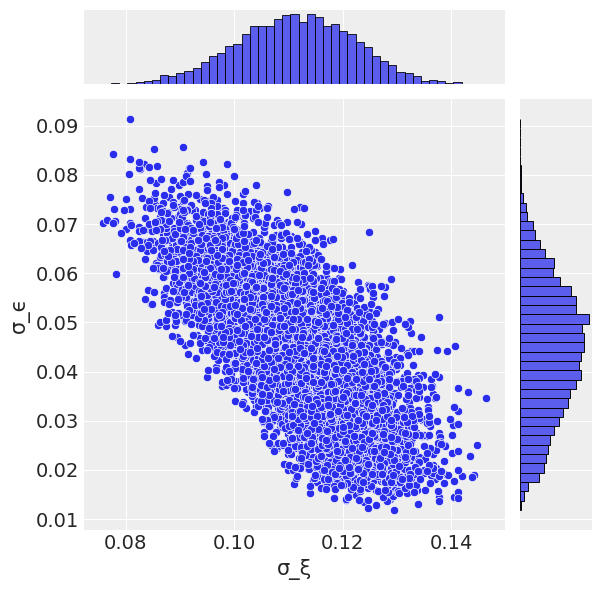

In [101]:
x_ = pd.Series(trace['σ_ξ'], name='σ_ξ')
y_ = pd.Series(trace['σ_ϵ'], name='σ_ϵ')

sns.jointplot(x=x_, y=y_);

They are highly negative correlated, that is why we are suffering. Sampling high values for one parameter results necessarily in low values for the other and vice versa. Therefore, it is hard for the sampler to decide what will be the best combination.

### 4.2 Using a trick to help on sampling

Another way of looking at our model is that it is unidentifiable. When we applied the Gaussian Random Walk prior, we defined a standard deviation for that adaptative prior and, at the same time, we defined a standard deviation for the likelihood. This means that for each observation we have two sources of variance and we are asking the sampler to decide which one matters more than the other. In a Bayesian framework we can always supply more informative priors to try to make the life of the sampler easier but in this case it is probably not enough.

To solve our problem we can add a new parameter to our model while removing one of the higly correlated ones. This new parameter controls the contribution of the two variances that we are dealing with. We are hoping that this small trick reduces the correlation of our parameters. You can see a different application of this trick here [[6]](https://docs.pymc.io/notebooks/GP-smoothing.html).

In [207]:
with pm.Model() as m2:
    σ_ϵ = pm.HalfNormal('σ_ϵ', 1)
    alpha = pm.Uniform('alpha', 0,1)
    μ = pm.GaussianRandomWalk('μ', 
                              sigma=σ_ϵ * (1.0 - alpha), 
                              shape=len(y))
    
    level = pm.Normal('level', 
                      mu=μ, 
                      sigma=σ_ϵ * alpha, 
                      observed=y)
    
    trace = pm.sample(2000,
                      target_accept=0.95,
                      init='advi+adapt_diag',
                      tune=3000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 21400
Interrupted at 21,399 [10%]: Average Loss = 8,823.4
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, alpha, σ_ϵ]


Sampling 4 chains for 3_000 tune and 2_000 draw iterations (12_000 + 8_000 draws total) took 24 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


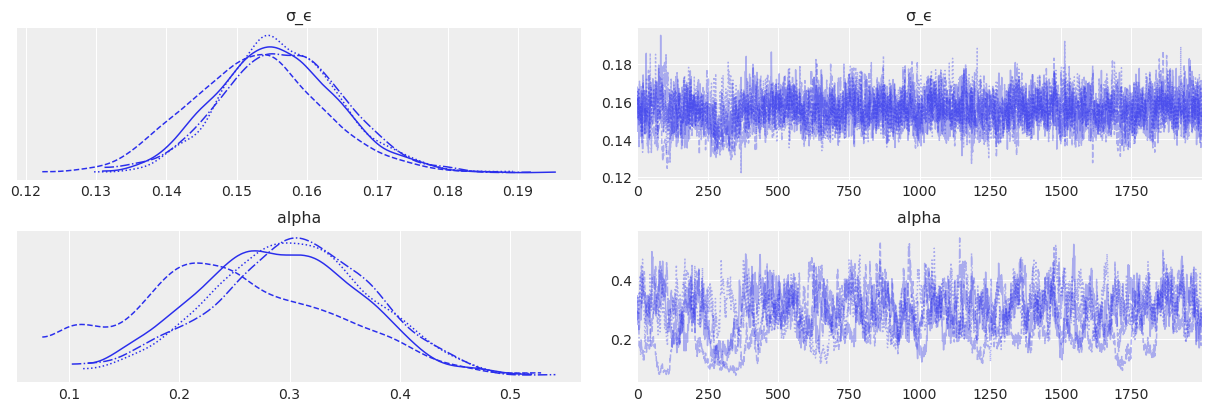

In [208]:
pm.traceplot(trace, var_names=['~μ']);

In [209]:
az.summary(trace, var_names=['~μ'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
σ_ϵ    0.155  0.009   0.138    0.172      0.001    0.000     172.0   172.0   
alpha  0.285  0.079   0.136    0.434      0.010    0.007      62.0    62.0   

       ess_bulk  ess_tail  r_hat  
σ_ϵ       166.0     357.0   1.02  
alpha      65.0      62.0   1.06

In [210]:
print(np.mean(trace['σ_ϵ'] * trace['alpha']))
print(np.mean(trace['σ_ϵ'] * (1- trace['alpha'])))

0.04458299664413166
0.11077738429704456


While the `r_hat`, mixing and `ess_mean` improved for `σ_ϵ`, we can see that we are still struglling with `alpha`. Let's check the joint posterior.

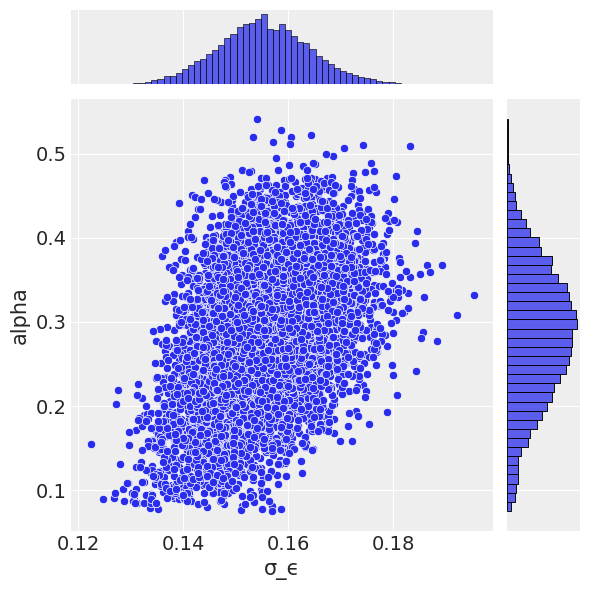

In [211]:
x_ = pd.Series(trace['σ_ϵ'], name='σ_ϵ')
y_ = pd.Series(trace['alpha'], name='alpha')

sns.jointplot(x=x_, y=y_);

It is much better than the one we saw previously, which indicates that the problem now is mainly our data. This is still not the best model to explain our data and our sampler is telling us that.

### 4.3 The cumulative sum

In the source code of the Gaussian Random Walk class [[7]](https://github.com/pymc-devs/pymc3/blob/4fd56fdeccf4550953b896f9af41c8b9b65b9ed8/pymc3/distributions/timeseries.py#L185) of `PyMC3` you can find a comment stating:

*Note that this is mainly a user-friendly wrapper to enable an easier specification of GRW. You are not restricted to use only Normal innovations but can use any distribution: just use `theano.tensor.cumsum()` to create the random walk behavior*

The comment is reinforcing what we have learnt above about what a Random Walk is. For our specific case, there is no clear benefit because we are using Normal innovations. Nonetheless, it opens the door for applications where this is not the case. You can plug in any distribution that explains better the behaviour of your time series. Another very commonly used are the Student-t innovations.

In [ ]:
with pm.Model() as m3:
    σ_ϵ = pm.HalfNormal('σ_ϵ', 1)
    alpha = pm.Uniform('alpha', 0,1)
    μ = pm.Normal('μ', sigma=σ_ϵ * (1.0 - alpha), shape=len(y))
    rw = tt.cumsum(μ)
    
    level = pm.Normal('level', 
                      mu=rw, 
                      sigma=σ_ϵ * alpha, 
                      observed=y)
    
    trace = pm.sample(2000,
                      target_accept=0.95,
                      init='advi+adapt_diag',
                      tune=5000)

I would not advise this implementation for our problem at hand as it is not the most efficient, nevertheless could be usefull in different settings.

### 4.4 Defining our own distribution

Now, it is time for us to get even more flexibility. As `PyMC3` has its built-in class, we can build our own and modify it as we wish. I simplified the code for the `GaussianRandomWalk` class and defined a new class - the `GRW`. We can see that we could, for instance, easily swap our `Normal.dist` and replace it with whatever distribution we want.

In [25]:
class GRW(distribution.Continuous):
    
    def __init__(self, sigma, mu=0, init=Flat.dist(), *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.sigma = tt.as_tensor_variable(sigma)
        self.mu = tt.as_tensor_variable(mu)
        self.init = init
        self.mean = tt.as_tensor_variable(0.0)
    
    def logp(self, x):
        x_im1 = x[:-1]
        x_i = x[1:]
        innov_like = Normal.dist(mu=x_im1 + self.mu, sigma=self.sigma).logp(x_i)
        return self.init.logp(x[0]) + tt.sum(innov_like)

In [26]:
with pm.Model() as m4:
    σ_ϵ = pm.HalfNormal('σ_ϵ', 0.5)
    
    alpha = pm.Uniform('alpha', 0,1)
    μ = GRW('μ', sigma=σ_ϵ * (1.0 - alpha), shape=len(y))

    level = pm.Normal('level', 
                      mu=μ, 
                      sigma=σ_ϵ * alpha, 
                      observed=y)
    
    trace = pm.sample(2000,
                      target_accept=0.95,
                      init='advi+adapt_diag',
                      tune=3000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 22800
Interrupted at 22,799 [11%]: Average Loss = 29,783
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, alpha, σ_ϵ]


Sampling 4 chains for 3_000 tune and 2_000 draw iterations (12_000 + 8_000 draws total) took 25 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


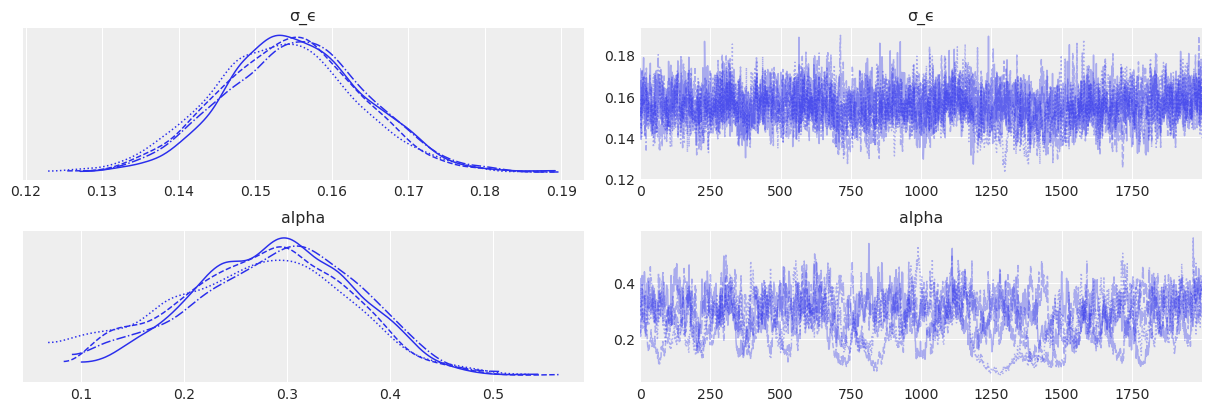

In [27]:
pm.traceplot(trace, var_names=['~μ']);

In [28]:
print(np.mean(trace['σ_ϵ'] * trace['alpha']))
print(np.mean(trace['σ_ϵ'] * (1 - trace['alpha'])))

0.04335492368248644
0.11142060608389621


### 4.5 Using Theano

`PyMC3` uses `Theano` to define functions involving array operations and linear algebra. In fact, when we define a `PyMC3` model, we implicitly build up a `Theano` function. Why is this important? Well, sometimes we need to take advantage of `Theano` features. This is the case with our current challenge.

The first one is quite simple, it is Theano `shared` feature. This is the way to use variables the way we use it in Python. Symbolic variables are not given an explicit value until one is assigned on the execution of a compiled `Theano` function. Using `Theano` `shared` variables, on the other side, assigns explicit values to the variables and these values are persisted in memory for the lifetime of the execution.

#### 4.5.1 Understanding Theano scan

The `Theano` function `scan` is a bit more challenging. In principle it is nothing more than a loop in `Theano`. But its usage is not so trivial. See more in their API docs here [[*8*]](https://theano-pymc.readthedocs.io/en/latest/library/scan.html?highlight=scan).

Let's see some examples to wrap our heads around it. Before that we just need to some insights on how it works:
- The parameter `sequences` is used to specify variables that `scan` should iterate over as it loops
- The parameter `non-sequences`, as the name indicates, is used to specify variables that are not iterated by `scan`, being passed as input to every iteration
- The parameter `fn` receives a function to be called once
- The parameter `outputs_info` is required when our function depend on an output of a previous iteration. It must be a tensor that `scan` will interpret it as being an initial state for a recurrent output and give it as input to the first iteration
- The first output after calling `scan` contains the outputs of `fn` from every timestep concatenated into a tensor
- The second output details if and how the execution of the `scan` updates any shared variable in the graph. It should be provided as an argument when compiling the Theano function.

We are ready to try it out. Let's make something up that tests us. Must be something that requires the reuse of outputs from previous iterations. Consider this expression

$$s_t = \alpha y_{t} + (1-\alpha)s_{t-1}$$

This is in fact an equation for a state-space model! It is the simplest form of exponential smoothing [[*9*]](https://en.wikipedia.org/wiki/Exponential_smoothing). We will not cover it, at least for now, but it is not that different from the models that we've been working with. It is another opportunity to touch base with important concepts that you will often see flying around in papers or textbooks. Exponential smoothing is a technique for smoothing time series data. Very briefly, it assigns exponentially decreasing weights to past observations. Our smoothing factor here is represented by $\alpha$ and is restricted by $0<\alpha<1$. We don't want to compute the model itself, but just use `scan` to perform the calculations to fit it to toy data.

We can immediately see that $\alpha$ is a `non-sequence` and a scalar parameter (does not depend on $t$), while $s$ and $y$ are `sequence` and vectors. We need to define an `output_info`, because our function depend on an output of a previous iteration. Finally, we need to define the initial value, that we will denote by variable `i`. Time to get our hands dirty.

In [43]:
theano.config.compute_test_value = 'ignore'

def step(s, y, s_previous, α):
    s = α*y + (1-α)*s_previous
    return s

s = T.vector('s')
y = T.vector('y')
α = T.scalar('α')
i = T.scalar('i')

output, updates = theano.scan(fn=step,
                              sequences=[s, y],
                              non_sequences=[α],
                              outputs_info=[i])

f = theano.function(inputs=[s, y, α, i],
                    outputs=output,
                    updates=updates)

s = np.zeros(9).astype(theano.config.floatX)
y = np.arange(9).astype(theano.config.floatX)
α = 0.7
i = 0

print(f(s, y, α, i)[0:5])

# Breaking it down to be more clear what is happening
iteration_1 = α*y[0] + i*(1-α)
iteration_2 = α*y[1] + iteration_1*(1-α)
iteration_3 = α*y[2] + iteration_2*(1-α)
iteration_4 = α*y[3] + iteration_3*(1-α)
iteration_5 = α*y[4] + iteration_4*(1-α)

print([iteration_1, 
       iteration_2, 
       iteration_3, 
       iteration_4, 
       iteration_5])

[0.     0.7    1.61   2.583  3.5749]
[0.0, 0.7, 1.6099999999999999, 2.5829999999999997, 3.5749]


Just a curiosity about python or any other programming language. Floating-point numbers are represented in computer hardware as base 2 (binary) fractions. And most of the decimal fractions can't really be represented exactly as binary fractions. You can see the impact on the strange long numbers in our manual calculations (you can read more here [[*10*]](https://docs.python.org/3/tutorial/floatingpoint.html))

The best way to avoid this is to use the `decimal` library.

In [66]:
s = np.zeros(9)
y = np.arange(0, 9)
α = Decimal('0.7')
i = 0

# Breaking it down to be more clear what is happening
iteration_1 = α*y[0] + i*(1-α)
iteration_2 = α*y[1] + iteration_1*(1-α)
iteration_3 = α*y[2] + iteration_2*(1-α)
iteration_4 = α*y[3] + iteration_3*(1-α)
iteration_5 = α*y[4] + iteration_4*(1-α)

print([float(iteration_1), 
       float(iteration_2), 
       float(iteration_3), 
       float(iteration_4), 
       float(iteration_5)])

[0.0, 0.7, 1.61, 2.583, 3.5749]


Exactly what we got from our `scan` function. Nice!

Feel free to play around with the parameters. 

#### 4.5.2 Model implementation

Now that we know how to use `scan`, we just need to plug in our use case. It is easier than the function that we have set up above, since we don't have a smoothing parameter here. We are simply performing the cumulative sum of our level over time.

In [218]:
def fn_μ_t(ξ_t, μ_previous):
    μ = μ_previous + ξ_t
    return μ

with pm.Model() as m5:
    σ_ϵ = pm.HalfNormal('σ_ϵ', 0.5)    
    smth_parm = pm.Uniform('alpha', 0,1)
    ξ = pm.Normal('ξ', mu=0, sigma=σ_ϵ * (1- smth_parm), shape=len(y))
    μ_1 = theano.shared(y[0])
    
    μ, updates = theano.scan(fn=fn_μ_t, 
                                    sequences = [ξ], 
                                    outputs_info = [μ_1], 
                                    n_steps=len(y))
    level = pm.Normal('level', mu=μ, sigma=σ_ϵ * smth_parm, observed=y)
    trace = pm.sample(2000,
                      target_accept=0.95,
                      init='advi+adapt_diag',
                      tune=3000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 19700
Interrupted at 19,699 [9%]: Average Loss = 30,446
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ξ, alpha, σ_ϵ]


Sampling 4 chains for 3_000 tune and 2_000 draw iterations (12_000 + 8_000 draws total) took 6336 seconds.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There were 51 divergences after tuning. Increase `target_accept` or reparameterize.
There were 74 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


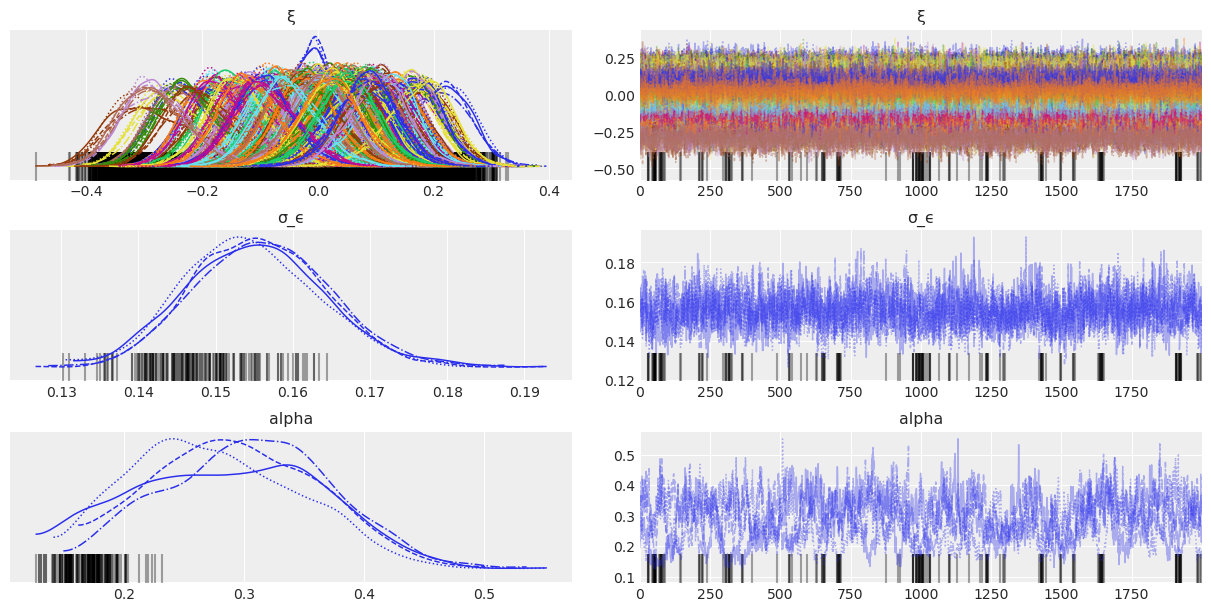

In [219]:
pm.traceplot(trace);

While this was an interesting exercise and specially helpfull to learn more how PyMC3 and Theano interact, I would not advise this implementation for our particular problem. It is not scalable (try it yourself and see how much time it takes to sample).

# 5. Discussion

Comparing our values calculated using both classical and Bayesian approaches, we see that we get close values (not exactly the same). Bayesian computations are a bit slower than when we use `statsmodels`, but, as we saw, we get much more flexibility. For instance, in case that you do not have normally distributed innovations we can change it very easily to any other distribution.

In [130]:
np.round(np.sqrt(model_fit.params),3)

array([0.047, 0.109])

In [133]:
print(np.round(np.mean(trace['σ_ϵ'] * trace['alpha']),3))
print(np.round(np.mean(trace['σ_ϵ'] * (1 - trace['alpha'])),3))

0.043
0.111


### 5.1 Classical implementation

Let's start by print the stochastic level and the observed time series.

In [161]:
dates = ["1969-01-01", "1984-12-31"]
start, end = [datetime.strptime(_, "%Y-%m-%d") for _ in dates]
time = list(OrderedDict(((start + timedelta(_)).strftime(r"%b-%y"), None) for _ in range((end - start).days)).keys())

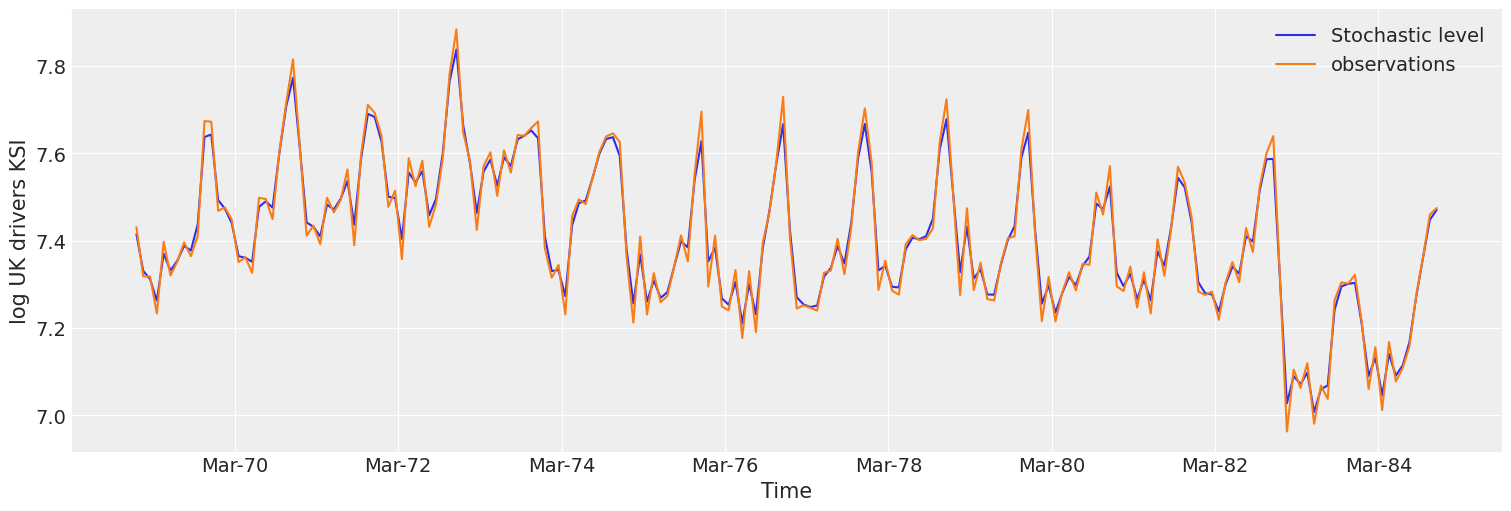

In [162]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(time, model_fit.level['smoothed'], label='Stochastic level')
ax.plot(time, y, label='observations')
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end, 12*2))
plt.ylabel('log UK drivers KSI')
plt.xlabel('Time', rotation=0)
ax.legend();

The plot looks good, meaning that when the level is allowed to vary over time we can match the observed values pattern. 

It is time to look at the diagnostics. We will extend a bit the number of lags that the default correlogram uses.

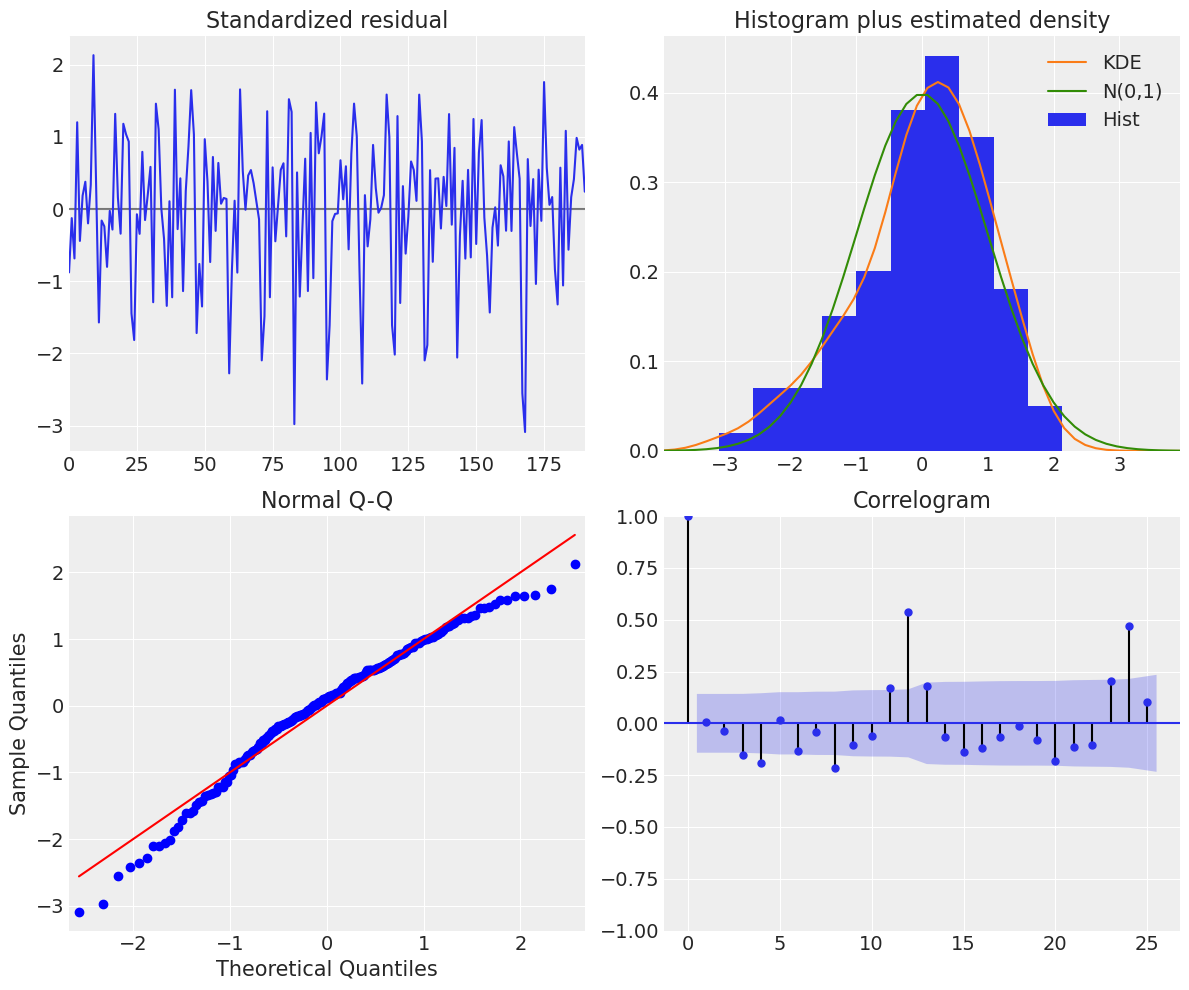

In [199]:
model_fit.plot_diagnostics(lags=25, figsize=(12, 10))
plt.tight_layout();

From the plots that we already know, the correlogram shows significant correlation at lag 12 and 24 (see the bars outside of the blue shadowed region).

We need to pay closer attention to the standardized residual plot. First, let's distinguish two concepts.

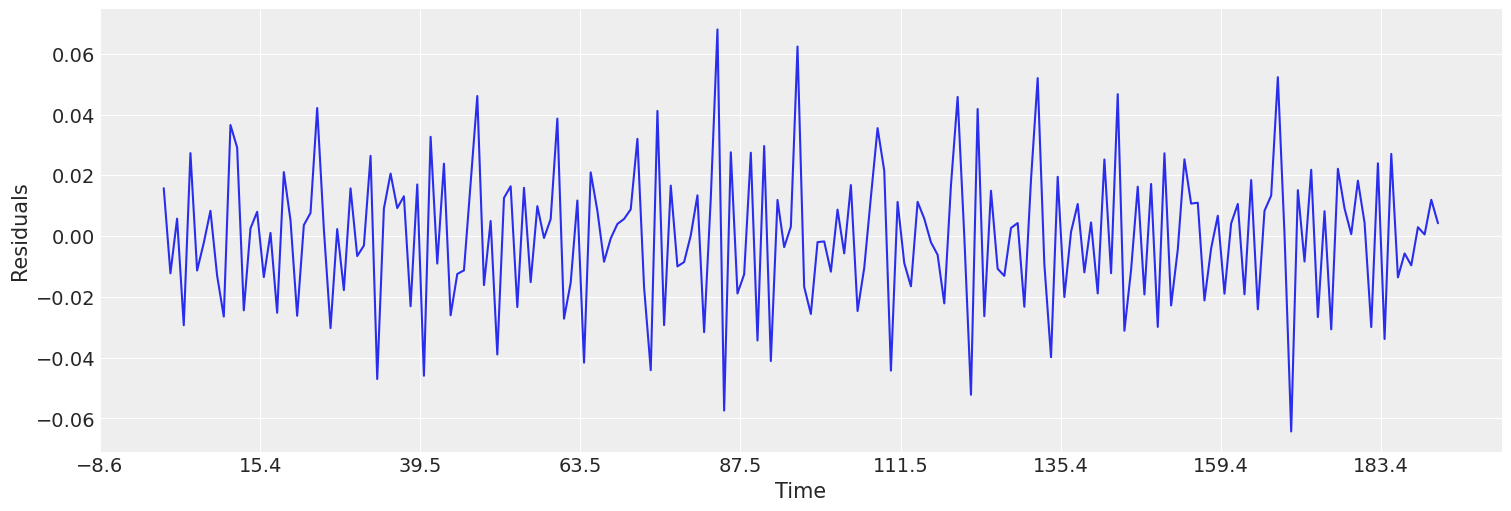

In [137]:
irregular_component = y - model_fit.smoothed_state[0]
_, ax = plt.subplots(figsize=(15,5))
ax.plot(t, irregular_component)
plt.ylabel('Residuals')
plt.xlabel('Time')
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end, 12*2));

The plot above with the difference between observations and the computed level appears to be composed of only independent random values (or *white noise*). This is in fact a plot of our irregular component and it is a good thing that it does not show any specific patterns.

Another thing are our prediction errors - i.e. our residuals. Remember that our next unobserved level $\mu_{t+1}$ depends on our current unobserved level $\mu_t$. If we were ploting one-step-ahead predictions, which is basically computing the forecast of the next point in our series $t+1$ using the information that we have until that moment, we would use the level at time $t$.

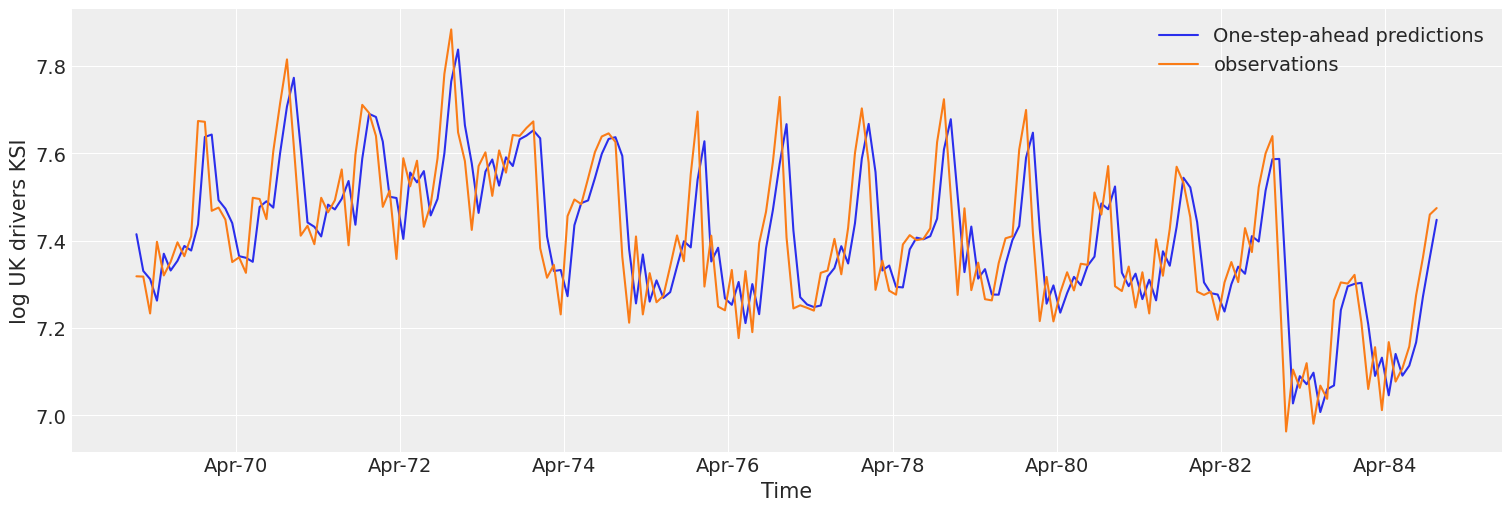

In [138]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(time[1:], model_fit.level['smoothed'][:-1], label='One-step-ahead predictions')
ax.plot(time[1:], y[1:], label='observations')
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end, 12*2))
plt.ylabel('log UK drivers KSI')
plt.xlabel('Time', rotation=0)
ax.legend();

We can see that our series of predictions are heavily influenced by the previous time step of the original series. Let's compute the residuals having this in mind. We can compute the residuals and normalize them.

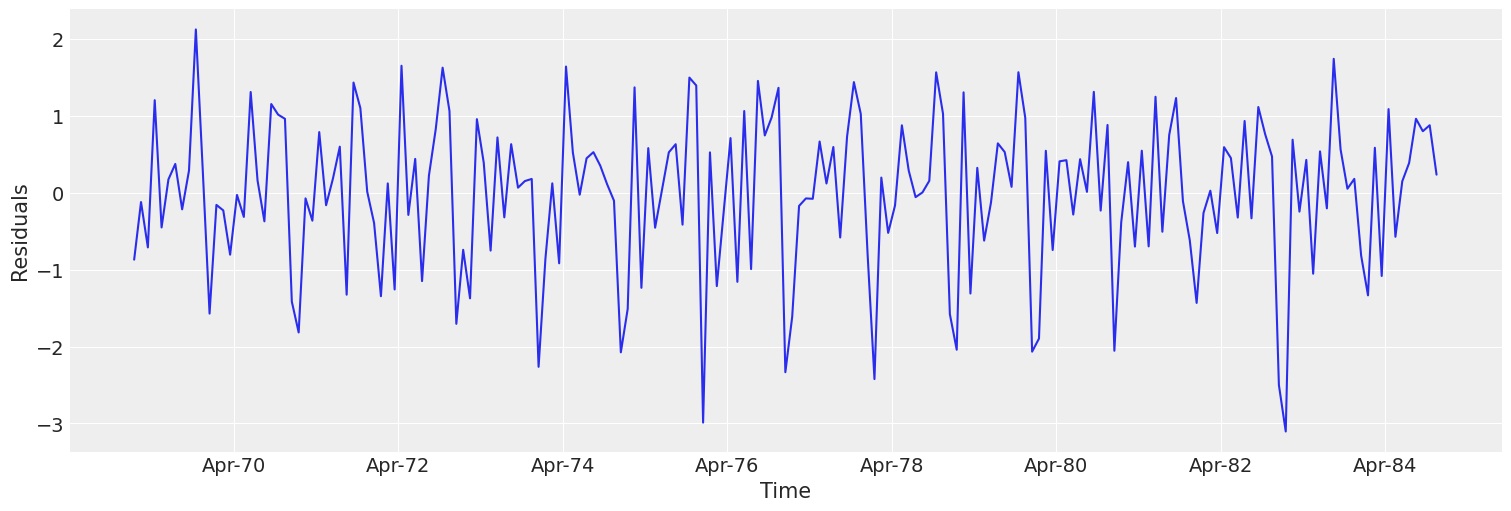

In [139]:
residuals = y[1:] - model_fit.smoothed_state[0][:-1]
residuals = (residuals - np.mean(residuals))/np.std(residuals)
_, ax = plt.subplots(figsize=(15,5))
ax.plot(time[1:], residuals)
plt.ylabel('Residuals')
plt.xlabel('Time')
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end, 12*2));

We can access the residuals from the `model_fit`. Another output that `statsmodels` give us is the plot on the upper right. We can easily plot it and it help us to understand what kind of distribution our residuals follow. We can also plot the Gaussian distribution with parameters $\mu = 0$ and $\sigma = 1$.

In [172]:
residuals = model_fit.standardized_forecasts_error[0,:]

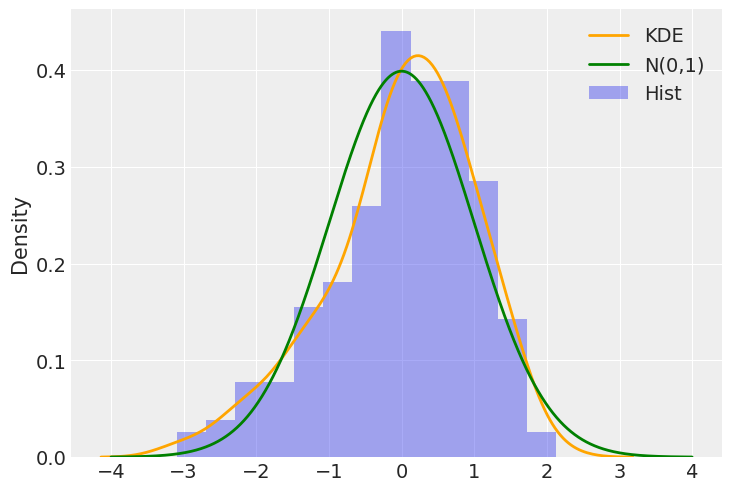

In [173]:
import seaborn as sns
ax = sns.distplot(residuals, 
                  kde_kws={"color": "orange", "lw": 2, "label": "KDE"},
                  hist_kws={"label":"Hist"})
x_ = np.arange(-4, +4, 0.001)                                                   
y_ = stats.norm.pdf(x_)                                    
ax.plot(x_, y_, 'g', lw=2, label='N(0,1)')   
ax.legend();

The distribution doesn't exactly follow a normal distribution but it is also not that far. There are some problems on the tails of the distribution. Let's analyze the last graph from `statsmodel`. It is the quantile-quantile plot. It generates an idealized distribution, in our case the gaussian distribution. The idealized samples are divided into groups or quantiles and each data point in the sample is paired with a similar member from the idealized distribution at the same cumulative distribution.

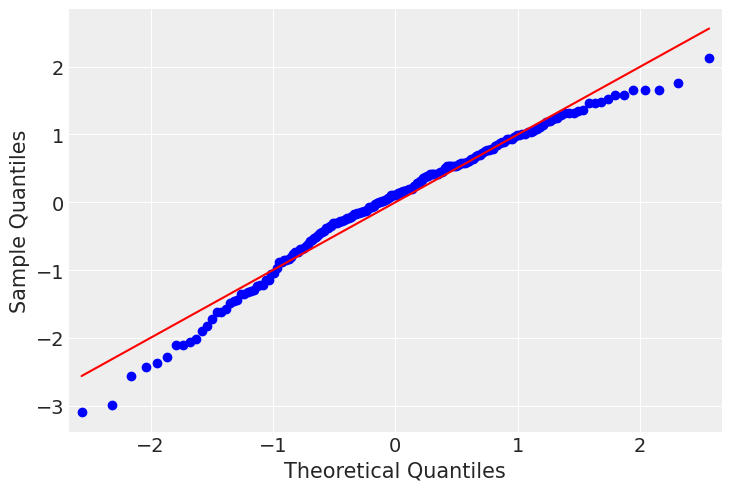

In [142]:
sm.qqplot(residuals, line='s');

A perfect match to a gaussian distribution would be shown by the points being always on top of the red line. This is not quite the case specially for the tails of the distribution. Since we focus much of the analysis of our residuals in terms of normality, we can also perform a statistical test and get a value if it is true of not (not very bayesian I know, but I just want you to know different approaches).

Let's do our hypothesis testing with the Jarque-Bera test for normality

$$N = n\big(\frac{S^2}{6} + \frac{(K-3)^2}{24} \big)$$

with 
$$S = \frac{ \frac{1}{n}\sum^n_{t=1}(e_t-\bar e)^3}{\sqrt{\big(\frac{1}{n}\sum^n_{t=1}(e_t-\bar e)^2\big)^3}} \quad \quad K = \frac{ \frac{1}{n}\sum^n_{t=1}(e_t - \bar e)^4} {{\big(\frac{1}{n}\sum^n_{t=1}(e_t-\bar e)^2\big)^2}}$$

where S denotes the skewness and K the kurtosis of the residuals.

In [143]:
resids = np.asarray(residuals)
skew = stats.skew(resids, axis=0)
kurtosis = 3 + stats.kurtosis(resids, axis=0)

n = resids.shape[0]
jb = (n / 6.) * (skew ** 2 + (1 / 4.) * (kurtosis - 3) ** 2)
jb_pv = stats.chi2.sf(jb, 2)

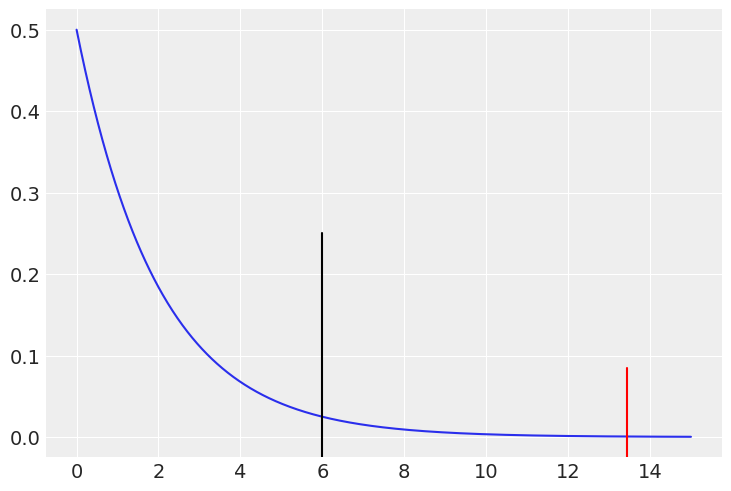

In [144]:
x = np.linspace(0, 15, 1000)
plt.plot(x, stats.chi2.pdf(x, 2))
plt.axvline(stats.chi2.ppf(0.95, 2), ymax=0.5, color='black')
plt.axvline(jb, ymax=0.2, color='red');

In the figure above we can see the $\chi^2_{(2)}$ distribution and its critical value at 5% (black line). The red line is the value for our data. With our computed value being $N > \chi^2_{(2;0.05)}$ the null hypothesis is rejected, i.e. the residuals are not normally distributed.

It all makes more sense now. With this small detour we also understood better what the `plot_components` function of `statsmodels` is showing us.

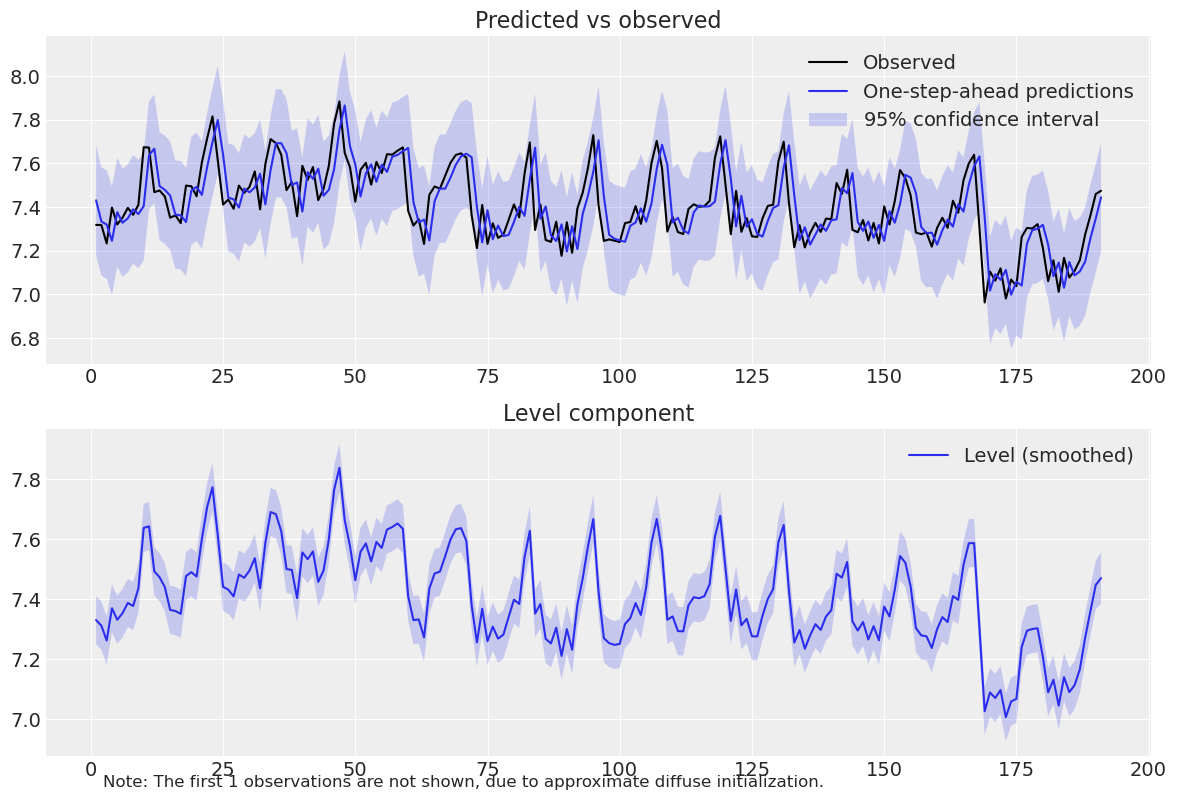

In [198]:
fig = model_fit.plot_components(figsize=(12, 8))
plt.tight_layout()

### 5.2 Bayesian implementation

In our Bayesian setting we already saw that there were problems with our model. We got that information from the sampling process directly through the convergences checks that we performed. Here we will skip the analysis that we did above, we should also check some properties of the residuals in a Bayesian context.

We will focus on the power available at our hands when we have access to posterior distributions. First, let's sample from our model.

In [205]:
with m2:
    ppc = pm.sample_posterior_predictive(trace, 200)

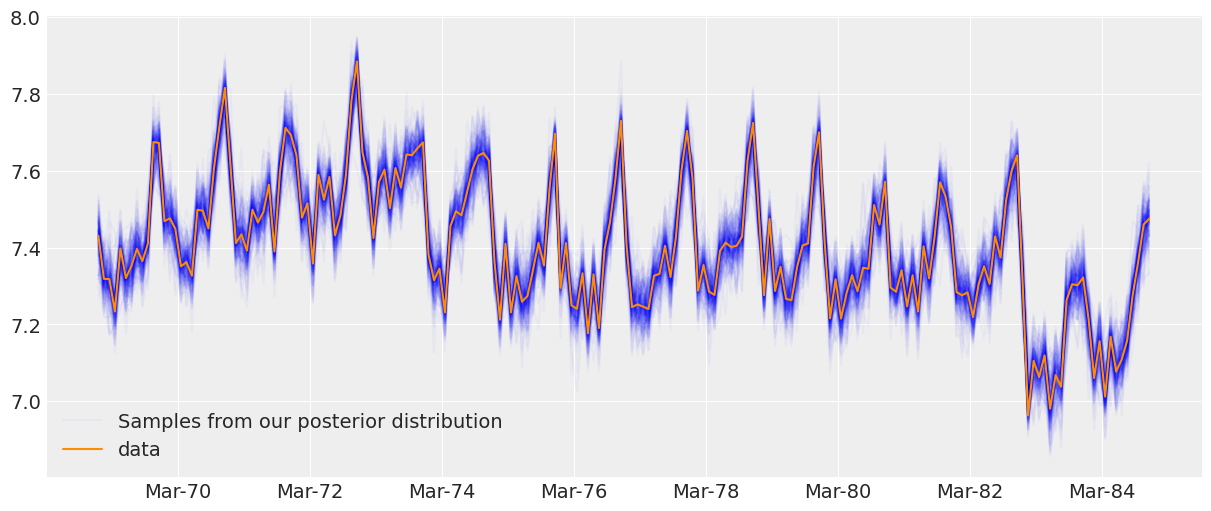

In [269]:
_, ax = plt.subplots(1,1,figsize=(12,5))

ax.plot(time, ppc['level'].T[:,1:], alpha=0.03, color='b', label='_')
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end, 12*2))


ax.plot(time,ppc['level'].T[:,1],alpha=0.03, color='b', label='Samples from our posterior distribution')
ax.plot(y, color='darkorange', label='data')
ax.legend();

Our samples look good, following the data close because of our stochastic level component. We can see that we are not plotting a single line but several lines, which creates an area of fitting. This area is our expression of uncertainty from our estimated parameters. We can do even better, plotting the mean, median and credible intervals. 

Just a word on the difference between credible intervals and confidence intervals. The first is the Bayesian version, which is a direct result of estimating a probability distribution for our parameters, intead of single point (it comes from the fact that in a Bayesian framework the parameters are treated as random variables). It summarizes the uncertainty and we can interpret it as the interval that includes 95% of the probability distribution area (we will see more interesting things that we can do with it). The latter is the frequentist approach. It consists in the range of values that includes the true value of the parameter 95% of the times that we repeat the experiment. This means that 5% of the experiments could, in theory, yield complete nonsense values, for instance, negative values for our observations of UK drivers KSI (read more here [[11]](https://stats.stackexchange.com/questions/2272/whats-the-difference-between-a-confidence-interval-and-a-credible-interval)).

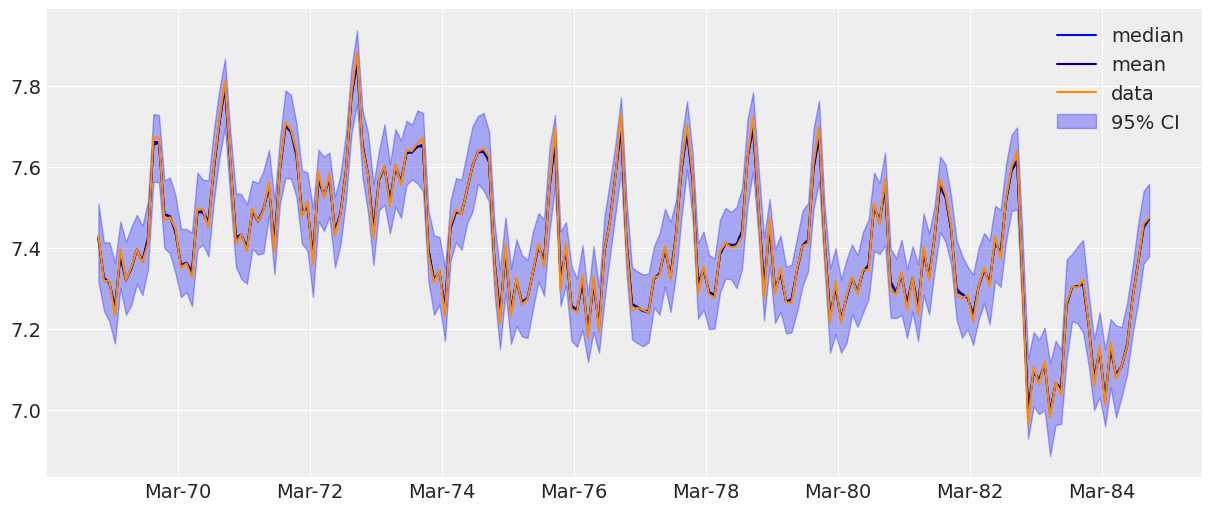

In [268]:
CI = np.percentile(ppc['level'], axis=0, q=[2.5, 50, 97.5])

mean = np.mean(ppc['level'], axis=0)

_, ax = plt.subplots(1, 1, figsize=(12,5))
ax.fill_between(time,CI[0], CI[2] ,alpha=0.3, color='b', label='95% CI')
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end, 12*2))
ax.plot(CI[1], color='b', label='median')
ax.plot(mean, color='darkblue', label='mean')
ax.plot(y, color='darkorange', label='data')
ax.legend();

Finally, just a recap of the idea of reparameterization that we did above. We had two variances contributing to a single observation, which created highly negative correlation between them. In an attempt to reduce this correlation, we replaced one of the parameters with a new one that, instead, controls the effect that each variance contributes to the observations. This resulted in much less correlation between our new parameters, despite the fact that it respects our first mathematical formulation of the problem (proven by the fact that we got identical results).

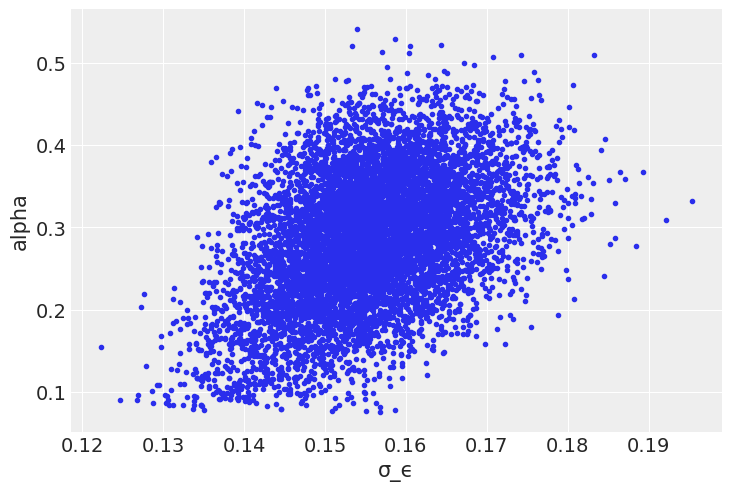

In [273]:
pm.pairplot(trace, var_names=['~μ']);

# 6. Conclusion

This article was a long one, but I am getting the feeling that we are starting to know more about our tools and use them to our advantage. The local level model is still not enough to explain our data, but it was another step closer. Just like a sampler, we are exploring the space and learning how it is shaped in the process. Stay tunned for the next article, we will start adding more components to our state!

# References

[1] J. Commandeur, S. Koopman, An Introduction to State-Space Time Series Analysis (2007), Oxford University Press

[2] https://en.wikipedia.org/wiki/Random_walk

[3] https://theano-pymc.readthedocs.io/en/latest/

[4] https://pymc-devs.medium.com/the-future-of-pymc3-or-theano-is-dead-long-live-theano-d8005f8a0e9b

[5] http://www.mcmchandbook.net/HandbookChapter6.pdf

[6] https://docs.pymc.io/notebooks/GP-smoothing.html

[7] https://github.com/pymc-devs/pymc3/blob/4fd56fdeccf4550953b896f9af41c8b9b65b9ed8/pymc3/distributions/timeseries.py#L185

[8] https://theano-pymc.readthedocs.io/en/latest/library/scan.html?highlight=scan

[9] https://en.wikipedia.org/wiki/Exponential_smoothing

[10] https://docs.python.org/3/tutorial/floatingpoint.html

[11] https://stats.stackexchange.com/questions/2272/whats-the-difference-between-a-confidence-interval-and-a-credible-interval)